# Imports e Upload

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb

# Configuracao MLflow

In [ ]:
import mlflow
import mlflow.sklearn
import os

# Configurar MLflow com caminho absoluto
notebook_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in dir() else os.getcwd()
mlruns_path = os.path.join(notebook_dir, "mlruns")
mlflow.set_tracking_uri(f"file:{mlruns_path}")
mlflow.set_experiment("Predicao_Precos_Carros")

print("MLflow configurado!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
experiment = mlflow.get_experiment_by_name('Predicao_Precos_Carros')
if experiment:
    print(f"Experimento ativo: {experiment.name} (ID: {experiment.experiment_id})")
else:
    print("Experimento criado: Predicao_Precos_Carros")

In [3]:
df = pd.read_csv("../data/raw/dataset_carros_brasil.csv")

# Análise Exploratória

In [4]:
df.shape

(10000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          10000 non-null  object 
 1   Modelo         10000 non-null  object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  10000 non-null  object 
 4   Cor            10000 non-null  object 
 5   Cambio         10000 non-null  object 
 6   Combustivel    10000 non-null  object 
 7   Portas         10000 non-null  int64  
 8   Valor_Venda    10000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 703.3+ KB


In [6]:
display(df)

,Marca,Modelo,Ano,Quilometragem,Cor,Cambio,Combustivel,Portas,Valor_Venda
0,Ford,EcoSport,2003.0,82624,Azul,Automático,Flex,4,52604.2
1,Hyundai,HB20S,2017.0,69260,Azul,Automático,Diesel,2,63219.0
2,Jeep,Renegade,2008.0,106493,Cinza,Manual,Gasolina,2,79710.4
3,Toyota,Corolla,2018.0,53570,Prata,Automático,Flex,2,99149.0
4,Ford,Ranger,2009.0,21643,Prata,Manual,Flex,2,68913.4
...,...,...,...,...,...,...,...,...,...
9995,Ford,EcoSport,2008.0,141618,Vermelho,Automático,Flex,2,47848.4
9996,Nissan,Frontier,2019.0,141820,Branco,Manual,Gasolina,2,69586.0
9997,Fiat,Cronos,2003.0,67089,Vermelho,Manual,Flex,4,36726.2
9998,Nissan,Versa,2000.0,191101,Cinza,Manual,Flex,2,31730.8


## Removendo nulos

In [7]:
# Remover linhas com qualquer valor nulo
df_clean = df.dropna()

print("Shape original:", df.shape)
print("Shape após remoção de nulos:", df_clean.shape)

# Conferir se ainda restaram valores nulos
print("\nValores nulos por coluna:")
print(df_clean.isna().sum())

Shape original: (10000, 9)
Shape após remoção de nulos: (9900, 9)

Valores nulos por coluna:
Marca            0
Modelo           0
Ano              0
Quilometragem    0
Cor              0
Cambio           0
Combustivel      0
Portas           0
Valor_Venda      0
dtype: int64


In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9900 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          9900 non-null   object 
 1   Modelo         9900 non-null   object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  9900 non-null   object 
 4   Cor            9900 non-null   object 
 5   Cambio         9900 non-null   object 
 6   Combustivel    9900 non-null   object 
 7   Portas         9900 non-null   int64  
 8   Valor_Venda    9900 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 773.4+ KB


## Verificando as colunas categóricas

In [9]:
categorical_cols = ["Marca", "Modelo", "Cor", "Cambio", "Combustivel", "Portas", "Quilometragem"]

for col in categorical_cols:
    uniques = df_clean[col].unique()
    print(f"\n{col}")
    print(f"Total de categorias: {len(uniques)}")
    print(uniques)


Marca
Total de categorias: 10
['Ford' 'Hyundai' 'Jeep' 'Toyota' 'Nissan' 'Fiat' 'Honda' 'Chevrolet'
 'Volkswagen' 'Renault']

Modelo
Total de categorias: 32
['EcoSport' 'HB20S' 'Renegade' 'Corolla' 'Ranger' 'Frontier' 'Toro'
 'Hilux' 'HB20' 'Argo' 'Civic' 'Onix Plus' 'HR-V' 'Gol' 'Kicks' 'Sandero'
 'Virtus' 'Versa' 'Yaris' 'Mobi' 'Ka' 'Kwid' 'Tracker' 'Creta' 'Cronos'
 'T-Cross' 'Compass' 'S10' 'Duster' 'Onix' 'Polo' 'Fit']

Cor
Total de categorias: 6
['Azul' 'Cinza' 'Prata' 'Preto' 'Vermelho' 'Branco']

Cambio
Total de categorias: 2
['Automático' 'Manual']

Combustivel
Total de categorias: 3
['Flex' 'Diesel' 'Gasolina']

Portas
Total de categorias: 2
[4 2]

Quilometragem
Total de categorias: 9559
['82624' '69260' '106493' ... '67089' '191101' '156313']


## Limpando a Quilometragem

In [10]:
# Contagem dos valores únicos
print(df_clean["Quilometragem"].value_counts().head(20))
print("\nTotal de valores distintos:", df_clean["Quilometragem"].nunique())

# Mostrar exemplos que não são numéricos
mask_non_numeric = df_clean["Quilometragem"].str.contains(r"[^\d\.]", regex=True, na=False)
print("\nExemplos de valores com texto dentro:")
print(df_clean.loc[mask_non_numeric, "Quilometragem"].unique()[:20])

Quilometragem
erro_medicao    99
166373           3
118222           3
124790           3
97491            3
95381            2
81254            2
125200           2
189928           2
73497            2
79942            2
44420            2
113417           2
56436            2
159701           2
142953           2
3801             2
76323            2
45832            2
51356            2
Name: count, dtype: int64

Total de valores distintos: 9559

Exemplos de valores com texto dentro:
['erro_medicao']


In [11]:
df_clean = df_clean[df_clean["Quilometragem"] != "erro_medicao"].copy()
print("Shape após remoção:", df_clean.shape)

Shape após remoção: (9801, 9)


In [12]:
df_clean.describe()

,Ano,Portas,Valor_Venda
count,9801.000000,9801.000000,9.801000e+03
mean,2011.509438,3.009693,8.320082e+04
std,6.897880,1.000004,1.672646e+05
min,2000.000000,2.000000,1.000000e+04
25%,2006.000000,2.000000,4.444760e+04
50%,2012.000000,4.000000,5.893580e+04
75%,2017.000000,4.000000,7.484280e+04
max,2023.000000,4.000000,1.241962e+06


## Arrumando os tipos

In [13]:
df_clean["Ano"] = df_clean["Ano"].astype(int)
df_clean["Quilometragem"] = df_clean["Quilometragem"].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9801 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          9801 non-null   object 
 1   Modelo         9801 non-null   object 
 2   Ano            9801 non-null   int64  
 3   Quilometragem  9801 non-null   float64
 4   Cor            9801 non-null   object 
 5   Cambio         9801 non-null   object 
 6   Combustivel    9801 non-null   object 
 7   Portas         9801 non-null   int64  
 8   Valor_Venda    9801 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 765.7+ KB


## Verificando Outliers (Ainda não apaguei)

In [14]:
# Função para contar outliers com base no IQR
def contar_outliers(grupo, coluna="Valor_Venda"):
    Q1 = grupo[coluna].quantile(0.25)
    Q3 = grupo[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = grupo[(grupo[coluna] < limite_inferior) | (grupo[coluna] > limite_superior)]
    return len(outliers)

# Calcular outliers por marca
outliers_por_marca = df_clean.groupby("Marca").apply(contar_outliers).reset_index(name="Qtd_Outliers")

# Ordenar do maior para o menor
outliers_por_marca = outliers_por_marca.sort_values(by="Qtd_Outliers", ascending=False)

outliers_por_marca.head(50)

C:\Users\renan\AppData\Local\Temp\ipykernel_31948\1224703819.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_marca = df_clean.groupby("Marca").apply(contar_outliers).reset_index(name="Qtd_Outliers")


,Marca,Qtd_Outliers
1,Fiat,28
0,Chevrolet,24
6,Nissan,24
7,Renault,23
9,Volkswagen,20
2,Ford,17
8,Toyota,17
4,Hyundai,16
5,Jeep,15
3,Honda,14


In [15]:
# Calcular outliers por modelo
outliers_por_modelo = df_clean.groupby("Modelo").apply(contar_outliers).reset_index(name="Qtd_Outliers")

# Ordenar do maior para o menor
outliers_por_modelo = outliers_por_modelo.sort_values(by="Qtd_Outliers", ascending=False)

outliers_por_modelo.head(50)

C:\Users\renan\AppData\Local\Temp\ipykernel_31948\2748338716.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_modelo = df_clean.groupby("Modelo").apply(contar_outliers).reset_index(name="Qtd_Outliers")


,Modelo,Qtd_Outliers
5,Cronos,12
9,Frontier,12
23,Renegade,10
17,Kwid,10
18,Mobi,9
19,Onix,8
15,Ka,8
20,Onix Plus,8
24,S10,7
31,Yaris,7


<Figure size 1200x600 with 0 Axes>

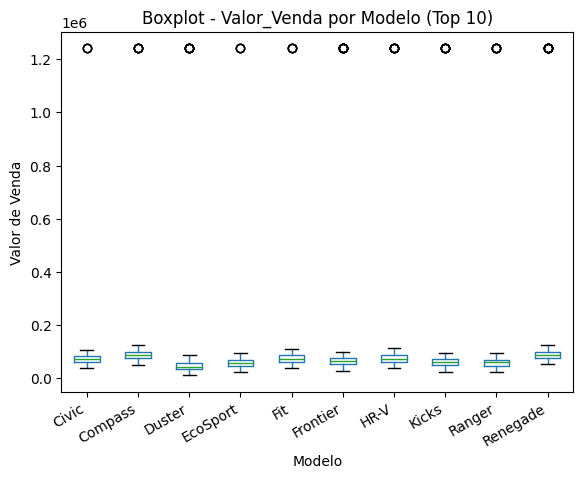

In [16]:
# Selecionar os 10 modelos mais frequentes
top_modelos = df_clean["Modelo"].value_counts().head(10).index
df_clean_top = df_clean[df_clean["Modelo"].isin(top_modelos)]

plt.figure(figsize=(12,6))
df_clean_top.boxplot(column="Valor_Venda", by="Modelo", showfliers=True, grid=False)
plt.title("Boxplot - Valor_Venda por Modelo (Top 10)")
plt.suptitle("")
plt.xlabel("Modelo")
plt.ylabel("Valor de Venda")
plt.xticks(rotation=30, ha="right")
plt.show()


# Removendo outliers por marca

In [17]:
df_clean = df.dropna()
df_clean = df_clean[df_clean["Quilometragem"] != "erro_medicao"].copy()
df_clean["Ano"] = df_clean["Ano"].astype(int)
df_clean["Quilometragem"] = df_clean["Quilometragem"].astype(float)


# Função que calcula os limites IQR e filtra o grupo
def remover_outliers_grupo(grupo, coluna='Valor_Venda'):
    Q1 = grupo[coluna].quantile(0.25)
    Q3 = grupo[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Retorna o grupo filtrado, mantendo apenas os valores dentro dos limites
    return grupo[(grupo[coluna] >= limite_inferior) & (grupo[coluna] <= limite_superior)]

# Agrupar o DataFrame por 'Marca'
# Aplicar a função a cada grupo
# Resetar o índice para juntar os grupos de volta em um único DataFrame
print(f"Shape antes da remoção de outliers por marca: {df_clean.shape}")

df_clean = df_clean.groupby('Marca').apply(remover_outliers_grupo).reset_index(drop=True)

print(f"Shape depois da remoção de outliers por marca: {df_clean.shape}")

df_clean.groupby('Marca')['Valor_Venda'].describe()

Shape antes da remoção de outliers por marca: (9801, 9)
Shape depois da remoção de outliers por marca: (9603, 9)


C:\Users\renan\AppData\Local\Temp\ipykernel_31948\1305782487.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('Marca').apply(remover_outliers_grupo).reset_index(drop=True)


,count,mean,std,min,25%,50%,75%,max
Marca,,,,,,,,
Chevrolet,948.0,48945.603797,16163.088247,10000.0,37261.15,48889.7,60768.65,88726.4
Fiat,947.0,45505.569588,15696.905728,10000.0,34254.30,45283.2,56588.20,84047.6
Ford,983.0,57247.147508,16012.054296,19524.2,45465.90,57526.6,69105.20,94471.6
Honda,989.0,72237.992315,16189.960476,36135.2,60135.40,72560.6,84195.00,111464.0
Hyundai,924.0,52751.791558,14525.435808,16951.0,43133.85,52743.0,62807.20,91396.2
Jeep,938.0,87053.177825,15832.594182,48862.6,75777.25,86984.6,97842.45,124196.2
Nissan,994.0,62089.731992,15931.669156,21502.6,50250.65,62408.8,73763.10,104107.6
Renault,949.0,44502.650580,15731.629170,10000.0,33453.20,43749.8,56012.80,85909.6
Toyota,920.0,76858.490217,15876.194927,36034.6,65603.20,76636.3,88092.75,118311.4


# Verificando duplicatas

In [18]:
print(f"Linhas duplicadas: {df_clean.duplicated().sum()}")
df_clean.drop_duplicates(inplace=True)

Linhas duplicadas: 0


# Criando features

In [19]:
from datetime import datetime

ano_atual = datetime.now().year
df_clean['Idade_Veiculo'] = ano_atual - df_clean['Ano']

df_clean.drop('Ano', axis=1, inplace=True)

In [20]:
# Adicionamos +1 na idade para evitar divisão por zero caso o carro seja do ano corrente
df_clean['Km_por_Ano'] = df_clean['Quilometragem'] / (df_clean['Idade_Veiculo'] + 1)

# Salvando dados processados

In [21]:
import os

# Criar diretório se não existir
os.makedirs('../data/processed', exist_ok=True)

# Salvar dados limpos em CSV
df_clean.to_csv('../data/processed/dataset_limpo.csv', index=False)

# Salvar também em pickle para preservar tipos
df_clean.to_pickle('../data/processed/dataset_limpo.pkl')

print(f"Dados processados salvos em data/processed/")
print(f"Total de registros: {len(df_clean)}")
print(f"Colunas: {list(df_clean.columns)}")

Dados processados salvos em data/processed/
Total de registros: 9603
Colunas: ['Marca', 'Modelo', 'Quilometragem', 'Cor', 'Cambio', 'Combustivel', 'Portas', 'Valor_Venda', 'Idade_Veiculo', 'Km_por_Ano']


In [22]:
df_modelo = df_clean.copy()

df_modelo = pd.get_dummies(df_modelo, columns=['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel'], drop_first=True)
X = df_modelo.drop('Valor_Venda', axis=1)
y = df_modelo['Valor_Venda']

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dicionário com os modelos que vamos treinar
modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1), # n_jobs=-1 usa todos os processadores
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

# Lista para armazenar os resultados
resultados = []

# Loop para treinar e avaliar cada modelo
print("Iniciando treinamento e avaliação dos modelos...")
for nome, modelo in modelos.items():
    print(f"Treinando {nome}...")
    # Treinar o modelo
    modelo.fit(X_train, y_train)

    # Fazer previsões
    previsoes = modelo.predict(X_test)

    # Calcular as métricas
    mae = mean_absolute_error(y_test, previsoes)
    rmse = np.sqrt(mean_squared_error(y_test, previsoes))
    r2 = r2_score(y_test, previsoes)

    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": nome,
        "MAE (R$)": mae,
        "RMSE (R$)": rmse,
        "R²": r2
    })

# Avaliação e Comparação
df_resultados = pd.DataFrame(resultados).sort_values(by='R²', ascending=False)

print("\nResultados Finais da Comparação dos Modelos")
print(df_resultados.round(4))

Iniciando treinamento e avaliação dos modelos...
Treinando Linear Regression...
Treinando Ridge Regression...
Treinando Lasso Regression...
Treinando Decision Tree...


c:\Users\renan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.839e+08, tolerance: 3.402e+08
  model = cd_fast.enet_coordinate_descent(


Treinando Random Forest...
Treinando Gradient Boosting...
Treinando XGBoost...
Treinando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 52
[LightGBM] [Info] Start training from score 59439.326550

Resultados Finais da Comparação dos Modelos
              Modelo   MAE (R$)  RMSE (R$)      R²
2   Lasso Regression  2527.4564  2917.8031  0.9803
0  Linear Regression  2528.4533  2919.5109  0.9803
1   Ridge Regression  2528.6220  2919.7418  0.9803
7           LightGBM  2599.5605  3083.2604  0.9780
5  Gradient Boosting  2714.0261  3234.9720  0.9758
4      Random Forest  2775.8137  3333.7535  0.9743
6        

# Teste hiperparametrizando

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore')

df_modelo = df_clean.copy()

df_modelo = pd.get_dummies(df_modelo, columns=['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel'], drop_first=True)
X = df_modelo.drop('Valor_Venda', axis=1)
y = df_modelo['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dicionário de modelos
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
}

# Grades de parâmetros para cada modelo
param_grids = {
    "Ridge": {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    "Lasso": {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 40]
    }
}

# Loop de Treinamento com GridSearchCV e MLflow
resultados_otimizados = []

print("Iniciando busca de hiperparâmetros com MLflow tracking...")
for nome, modelo in modelos.items():
    print(f"Otimizando {nome}...")
    
    # Iniciar run do MLflow
    with mlflow.start_run(run_name=f"{nome}_GridSearch"):
        
        # GridSearchCV
        grid_search = GridSearchCV(modelo, param_grids[nome], cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        melhor_modelo = grid_search.best_estimator_
        
        # Predições
        previsoes = melhor_modelo.predict(X_test)
        
        # Métricas
        mae = mean_absolute_error(y_test, previsoes)
        rmse = np.sqrt(mean_squared_error(y_test, previsoes))
        r2 = r2_score(y_test, previsoes)
        
        # LOGGING NO MLFLOW
        # 1. Parâmetros
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("modelo_tipo", nome)
        mlflow.log_param("cv_folds", 5)
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)
        
        # 2. Métricas
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)
        
        # 3. Dataset info
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_param("n_train_samples", X_train.shape[0])
        mlflow.log_param("n_test_samples", X_test.shape[0])
        
        # 4. Modelo
        mlflow.sklearn.log_model(melhor_modelo, f"model_{nome.replace(' ', '_')}")
        
        # 5. Tags para organização
        if nome in ["XGBoost", "LightGBM"]:
            mlflow.set_tag("framework", nome)
        else:
            mlflow.set_tag("framework", "scikit-learn")
        
        if nome in ["Ridge", "Lasso"]:
            mlflow.set_tag("model_family", "linear")
        else:
            mlflow.set_tag("model_family", "tree-based")
        
        resultados_otimizados.append({
            "Modelo": nome,
            "MAE (R$)": mae,
            "RMSE (R$)": rmse,
            "R²": r2,
            "Melhores Parâmetros": grid_search.best_params_,
            "MLflow Run ID": mlflow.active_run().info.run_id
        })
        
        print(f"  Registrado no MLflow (Run ID: {mlflow.active_run().info.run_id[:8]}...)")

# Comparação dos Resultados Otimizados
df_resultados_otimizados = pd.DataFrame(resultados_otimizados).sort_values(by='R²', ascending=False)

print("\nResultados Finais dos Modelos Otimizados")
print("\nTodos os experimentos registrados no MLflow!")
pd.set_option('display.max_colwidth', None)
df_resultados_otimizados.round(4)

Iniciando busca de hiperparâmetros com MLflow tracking...
Otimizando Ridge...


2025/09/30 21:38:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: d496d0e8...)
Otimizando Lasso...


2025/09/30 21:38:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:38:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 185fb669...)
Otimizando Random Forest...


2025/09/30 21:39:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:39:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 1e0b2d1e...)
Otimizando Gradient Boosting...


2025/09/30 21:39:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:39:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 96265df3...)
Otimizando XGBoost...


2025/09/30 21:39:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:39:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: c75d0e94...)
Otimizando LightGBM...


2025/09/30 21:39:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:39:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Registrado no MLflow (Run ID: 41e5b9a8...)

Resultados Finais dos Modelos Otimizados

Todos os experimentos registrados no MLflow!


,Modelo,MAE (R$),RMSE (R$),R²,Melhores Parâmetros,MLflow Run ID
1,Lasso,2527.4564,2917.8031,0.9803,{'alpha': 1.0},185fb6692f7d431f9a85661bb6b018f9
0,Ridge,2528.6220,2919.7418,0.9803,{'alpha': 1.0},d496d0e81c4245388699aa9eba1a535f
4,XGBoost,2600.4039,3058.3697,0.9784,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}",c75d0e9478974cd986ba939b49d109d2
3,Gradient Boosting,2609.8190,3063.9909,0.9783,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}",96265df37b774367a6700ccc2399b4b2
5,LightGBM,2611.7957,3085.4706,0.9780,"{'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31}",41e5b9a8dd8e48c0909a3f2d2749806f
2,Random Forest,2746.9229,3293.2949,0.9749,"{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}",1e0b2d1e0a394803a55d592f50995501


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# Criar diretório para as imagens se não existir
os.makedirs('../reports/figures', exist_ok=True)

df_modelo = df_clean.copy()

df_modelo = pd.get_dummies(df_modelo, columns=['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel'], drop_first=True)
X = df_modelo.drop('Valor_Venda', axis=1)
y = df_modelo['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos e Grades de Parâmetros
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}
param_grids = {
    "Ridge": {'alpha': [0.1, 1.0, 10.0]},
    "Lasso": {'alpha': [0.1, 1.0, 10.0]},
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'max_depth': [3]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'max_depth': [3]},
    "LightGBM": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'num_leaves': [31]}
}

# Loop de Treinamento, Avaliação e PLOTAGEM
print("Iniciando busca de hiperparâmetros e geração de gráficos...")
for nome, modelo in modelos.items():
    print(f"Otimizando e analisando {nome}...")

    grid_search = GridSearchCV(modelo, param_grids[nome], cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    melhor_modelo = grid_search.best_estimator_

    # Extração e Plotagem da Importância das Features

    # Verificar se o modelo tem 'feature_importances_' (modelos de árvore) ou 'coef_' (modelos lineares)
    if hasattr(melhor_modelo, 'feature_importances_'):
        importances = melhor_modelo.feature_importances_
    elif hasattr(melhor_modelo, 'coef_'):
        importances = np.abs(melhor_modelo.coef_)
    else:
        continue # Pula para o próximo modelo se não tiver como medir a importância

    # Criar um DataFrame de features e suas importâncias
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Pegar as 20 features mais importantes para o gráfico
    top_20_features = feature_importance_df.head(20)

    # Criar o gráfico
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
    plt.title(f'Top 20 Features Mais Importantes - {nome}', fontsize=16)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout() # Ajusta o layout para não cortar os nomes

    # Salvar o gráfico no diretório correto
    plt.savefig(f'../reports/figures/importancia_features_{nome.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.clf() # Limpa a figura para o próximo gráfico

print("\nGráficos salvos em reports/figures/")

Iniciando busca de hiperparâmetros e geração de gráficos...
Otimizando e analisando Ridge...
Otimizando e analisando Lasso...
Otimizando e analisando Random Forest...
Otimizando e analisando Gradient Boosting...
Otimizando e analisando XGBoost...
Otimizando e analisando LightGBM...

Gráficos salvos em reports/figures/


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

# Salvando Metricas dos Modelos

In [25]:
import os
import json

# Criar diretório se não existir
os.makedirs('../reports/metrics', exist_ok=True)

# Salvar métricas em CSV
df_resultados_otimizados.to_csv('../reports/metrics/resultados_modelos.csv', index=False)

# Salvar métricas em JSON (mais estruturado)
df_resultados_otimizados.to_json('../reports/metrics/resultados_modelos.json', orient='records', indent=2)

print("Metricas salvas em reports/metrics/")
print(f"\nResumo:")
print(f"- Melhor modelo: {df_resultados_otimizados.iloc[0]['Modelo']}")
print(f"- R² Score: {df_resultados_otimizados.iloc[0]['R²']:.4f}")
print(f"- MAE: R$ {df_resultados_otimizados.iloc[0]['MAE (R$)']:.2f}")
print(f"- RMSE: R$ {df_resultados_otimizados.iloc[0]['RMSE (R$)']:.2f}")

Metricas salvas em reports/metrics/

Resumo:
- Melhor modelo: Lasso
- R² Score: 0.9803
- MAE: R$ 2527.46
- RMSE: R$ 2917.80


# Salvando Modelo Campeao

In [26]:
import os
import joblib
from sklearn.linear_model import Lasso
import mlflow
import mlflow.sklearn

# Criar diretorio se nao existir
os.makedirs('../models/trained_models', exist_ok=True)

# Treinar o modelo campeao (Lasso) com os melhores parametros
modelo_campeao = Lasso(alpha=1.0)
modelo_campeao.fit(X_train, y_train)

# Registrar modelo campeão no MLflow Model Registry
with mlflow.start_run(run_name="Modelo_Campeao_Lasso"):
    
    # Métricas finais
    previsoes_final = modelo_campeao.predict(X_test)
    mae_final = mean_absolute_error(y_test, previsoes_final)
    rmse_final = np.sqrt(mean_squared_error(y_test, previsoes_final))
    r2_final = r2_score(y_test, previsoes_final)
    
    # Logging
    mlflow.log_param("alpha", 1.0)
    mlflow.log_param("modelo", "Lasso")
    mlflow.log_metric("mae", mae_final)
    mlflow.log_metric("rmse", rmse_final)
    mlflow.log_metric("r2_score", r2_final)
    
    # Registrar modelo no MLflow
    mlflow.sklearn.log_model(
        modelo_campeao, 
        "modelo_campeao",
        registered_model_name="PredicaoCarros_Lasso_Campeao"
    )
    
    # Salvar artefatos adicionais
    mlflow.log_artifact('../reports/metrics/resultados_modelos.json')
    
    # Tags
    mlflow.set_tag("status", "producao")
    mlflow.set_tag("versao", "1.0")
    mlflow.set_tag("framework", "scikit-learn")
    
    run_id = mlflow.active_run().info.run_id
    print(f"Modelo campeao registrado no MLflow (Run ID: {run_id[:8]}...)")

# Salvar localmente também (backup)
joblib.dump(modelo_campeao, '../models/trained_models/lasso_modelo_campeao.pkl')

feature_info = {
    'features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'modelo': 'Lasso',
    'parametros': {'alpha': 1.0},
    'mlflow_registered': True,
    'model_registry_name': 'PredicaoCarros_Lasso_Campeao'
}

import json
with open('../models/trained_models/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print("\nModelo campeao salvo!")
print(f"  Local: models/trained_models/lasso_modelo_campeao.pkl")
print(f"  MLflow Model Registry: PredicaoCarros_Lasso_Campeao")
print(f"  Metricas: R²={r2_final:.4f}, MAE=R${mae_final:.2f}, RMSE=R${rmse_final:.2f}")

2025/09/30 21:40:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 21:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo campeao registrado no MLflow (Run ID: 191aef06...)

Modelo campeao salvo!
  Local: models/trained_models/lasso_modelo_campeao.pkl
  MLflow Model Registry: PredicaoCarros_Lasso_Campeao
  Metricas: R²=0.9803, MAE=R$2527.46, RMSE=R$2917.80


Registered model 'PredicaoCarros_Lasso_Campeao' already exists. Creating a new version of this model...
Created version '2' of model 'PredicaoCarros_Lasso_Campeao'.


# Visualizando Experimentos no MLflow

Para visualizar todos os experimentos registrados, execute em um terminal:

```bash
cd notebooks
mlflow ui --port 5000
```

Depois acesse: http://localhost:5000

## O que voce vera:
- **Experiments**: Comparacao de todos os 6 modelos treinados
- **Parametros**: Hiperparametros de cada modelo
- **Metricas**: MAE, RMSE, R² de cada experimento
- **Artifacts**: Modelos salvos e arquivos de metricas
- **Model Registry**: Modelo campeao registrado para producao

## Modelo Registrado:
- **Nome**: PredicaoCarros_Lasso_Campeao
- **Versao**: 1.0
- **Status**: Producao

# Testando MLflow - Visualizando Experimentos

Vamos verificar se todos os experimentos foram registrados corretamente:

In [28]:
import mlflow
import pandas as pd

# Buscar todos os experimentos
experimentos = mlflow.search_experiments()
print("Experimentos disponiveis:")
for exp in experimentos:
    print(f"  - {exp.name} (ID: {exp.experiment_id})")

# Buscar todos os runs do experimento principal
runs = mlflow.search_runs(experiment_names=["Predicao_Precos_Carros"])

print(f"\nTotal de runs: {len(runs)}")
print("\nResumo dos experimentos (ordenado por R² Score):")

# Selecionar colunas relevantes
colunas_importantes = [
    'tags.mlflow.runName',
    'metrics.r2_score', 
    'metrics.mae',
    'metrics.rmse',
    'params.modelo_tipo',
    'start_time'
]

# Filtrar apenas as colunas que existem
colunas_existentes = [col for col in colunas_importantes if col in runs.columns]

# Mostrar resultados
runs_resumo = runs[colunas_existentes].sort_values('metrics.r2_score', ascending=False)
runs_resumo.rename(columns={
    'tags.mlflow.runName': 'Nome do Run',
    'metrics.r2_score': 'R² Score',
    'metrics.mae': 'MAE',
    'metrics.rmse': 'RMSE',
    'params.modelo_tipo': 'Modelo'
}, inplace=True)

display(runs_resumo)

Experimentos disponiveis:
  - Predicao_Precos_Carros (ID: 952608842550762447)
  - Default (ID: 0)

Total de runs: 14

Resumo dos experimentos (ordenado por R² Score):


,Nome do Run,R² Score,MAE,RMSE,Modelo,start_time
0,Modelo_Campeao_Lasso,0.980334,2527.456400,2917.803059,None,2025-10-01 00:40:05.439000+00:00
5,Lasso_GridSearch,0.980334,2527.456400,2917.803059,Lasso,2025-10-01 00:38:54.293000+00:00
12,Lasso_GridSearch,0.980334,2527.456400,2917.803059,Lasso,2025-10-01 00:29:31.124000+00:00
7,Modelo_Campeao_Lasso,0.980334,2527.456400,2917.803059,None,2025-10-01 00:30:40.250000+00:00
6,Ridge_GridSearch,0.980308,2528.621993,2919.741802,Ridge,2025-10-01 00:38:44.737000+00:00
13,Ridge_GridSearch,0.980308,2528.621993,2919.741802,Ridge,2025-10-01 00:29:19.784000+00:00
9,XGBoost_GridSearch,0.978393,2600.403908,3058.369717,XGBoost,2025-10-01 00:30:14.867000+00:00
2,XGBoost_GridSearch,0.978393,2600.403908,3058.369717,XGBoost,2025-10-01 00:39:39.191000+00:00
3,Gradient Boosting_GridSearch,0.978314,2609.819026,3063.990866,Gradient Boosting,2025-10-01 00:39:25.389000+00:00
10,Gradient Boosting_GridSearch,0.978314,2609.819026,3063.990866,Gradient Boosting,2025-10-01 00:30:01.869000+00:00


## Comparacao Visual dos Modelos

Criando um grafico comparando as metricas dos modelos:

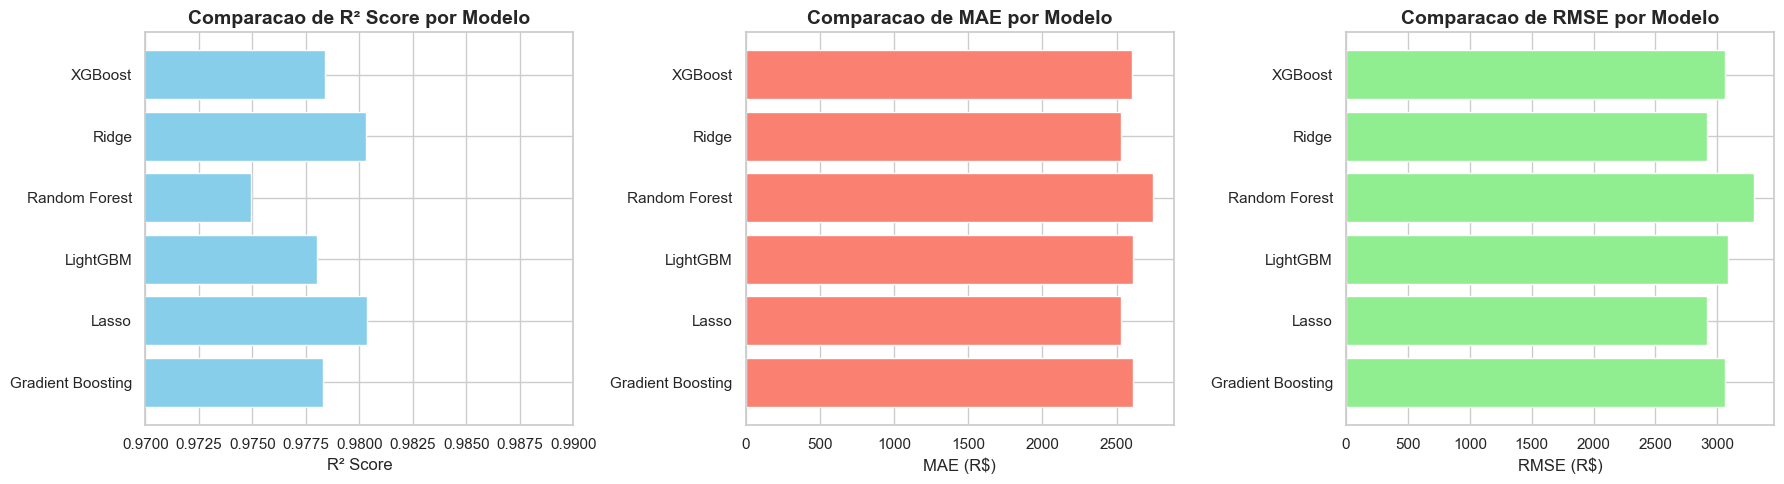

Grafico salvo em reports/figures/mlflow_comparacao_modelos.png


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar apenas os runs de GridSearch (excluir duplicatas)
runs_grid = runs[runs['tags.mlflow.runName'].str.contains('GridSearch', na=False)]

# Preparar dados para visualizacao
modelos_unicos = runs_grid.groupby('params.modelo_tipo').first().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafico 1: R² Score
axes[0].barh(modelos_unicos['params.modelo_tipo'], modelos_unicos['metrics.r2_score'], color='skyblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Comparacao de R² Score por Modelo', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.97, 0.99)

# Grafico 2: MAE
axes[1].barh(modelos_unicos['params.modelo_tipo'], modelos_unicos['metrics.mae'], color='salmon')
axes[1].set_xlabel('MAE (R$)', fontsize=12)
axes[1].set_title('Comparacao de MAE por Modelo', fontsize=14, fontweight='bold')

# Grafico 3: RMSE
axes[2].barh(modelos_unicos['params.modelo_tipo'], modelos_unicos['metrics.rmse'], color='lightgreen')
axes[2].set_xlabel('RMSE (R$)', fontsize=12)
axes[2].set_title('Comparacao de RMSE por Modelo', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/mlflow_comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvo em reports/figures/mlflow_comparacao_modelos.png")